In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pyregion

In [2]:
def first_and_last_indices_above_one(numbers):
    above_one_indices = [i for i, num in enumerate(numbers) if num > 0]
    return above_one_indices[0] if above_one_indices else None, above_one_indices[-1] if above_one_indices else None

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def perp_line(m, x1, y1, x): 
    y = m*(x-x1) + y1 
    return y 

def per_star(r, image, num): 
    
    width = 16
    
    y = round(r[num].coord_list[0])
    x = round(r[num].coord_list[1])

    cutout = image[0].data[x-width:x+width,y-width:y+width]
    rows, cols = np.where(cutout>1)
    fit = np.polyfit(rows, cols, 2)
    f = np.poly1d(fit)

    starlist = []
    
    x_vals = range(round(cutout.shape[0]/2-5),round(cutout.shape[0]/2+5))
    
    for x_val in x_vals: 

        deriv = f.deriv()
        slope_of_normal = -1/deriv(x_val)
        y1 = f(x_val)
        x1= x_val
        xr = range(x_val-8,x_val+12)

        y = [round(perp_line(slope_of_normal, x1, y1, x)) for x in xr]
        y = [31 if a >= 32 else 0 if a <= 0 else a for a in y]
        #plt.scatter(xr, y, marker ='x')
        coords = list(zip(xr,y))
        crosscut = [cutout[c[0],c[1]] for c in coords]
        
        try:
            popt, _ = curve_fit(gaussian, xr, crosscut, p0=[1, 0, 1])

            # Calculate the FWHM from the fitted parameters
            fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]
            
            first_index, last_index = first_and_last_indices_above_one(crosscut)
            width = last_index-first_index 
            
            maxy = max(crosscut)
            rsum = sum(crosscut)-maxy
            rstd = np.std(crosscut)
            rmean = np.mean(crosscut)
            maxy2 = sorted(crosscut)[-2]
            numg0 = sum(i > 1 for i in crosscut)            
            numge1 = sum(i >= 1 for i in crosscut)


        except: 
            fwhm = 999
            
        row = {'star': num, 
               'x_val': x_val, 
               'fwhm': fwhm, 
               'maxy': maxy,
               'maxy2': maxy2,
               'crosscut': crosscut, 
               'rsum': rsum,
              'rmean': rmean,
              'rstd': rstd,
              'numg0': numg0,
              'numge1': numge1,
              'width': width,
              'first_index': first_index,
              'last_index': last_index} 
        
        starlist.append(row.copy())

        
    star_data = pd.DataFrame(starlist)
    
    return star_data 
        
def per_eclipse(eclipse, time, timer): 
    
    image = fits.open(f"/media/bekah/BekahA/backplane_widths/e{eclipse}/e{eclipse}-nd-b00-f0025-t00{time}0-g_dose.fits.gz")
    region_name = f"/media/bekah/BekahA/backplane_widths/e{eclipse}/regions_n_t{timer}.reg"
    r = pyregion.open(region_name)
    
    combined_results = []

    for star in range(len(r)): 
        try: 
            star_data = per_star(r, image, star)
            combined_results.append(star_data)
        except: 
            print("Poor fit.")
        
    eclipse_results = pd.concat(combined_results, axis=0)
    eclipse_results['eclipse'] = eclipse
    eclipse_results['time'] = timer

    return eclipse_results 

def all_data(dlist): 
    
    combined_results = []
    
    for d in dlist: 
        df = per_eclipse(d[0], d[1], d[2])
        combined_results.append(df)
        
                    
    return combined_results 


In [3]:
dlist = [('23068', '25', '25'), ('23068', '50', '50'),
            ('23068', '75', '75'), ('23068', '00', '0'), 
           ('23258', '25', '25'), ('23258', '50', '50'),
            ('23258', '75', '75'), ('23258', '00', '0'),
        ('23328','25', '25'),('23328','50', '50'),
        ('23334','00','0'), ('23334','25','25')]

cresults = all_data(dlist)

df = pd.concat(cresults, axis=0)
df.to_csv('/home/bekah/glcat/fuv_offset/streak_widths.csv', index=False)  

FileNotFoundError: [Errno 2] No such file or directory: '/media/bekah/BekahA/backplane_widths/e23068/e23068-nd-b00-f0025-t00250-g_dose.fits.gz'

In [ ]:
length = len(results)
norm = [abs((c-9)/9) for c in range(20)]

length = len(results)
for x in range(length): 
    plt.scatter(norm,results['crosscut'].iloc[x])
    
length = len(results1)
for x in range(length): 
    plt.scatter(norm,results1['crosscut'].iloc[x])
    
length = len(results2)
for x in range(length): 
    plt.scatter(norm,results2['crosscut'].iloc[x])
    


In [ ]:
results

In [ ]:
plt.hist(results['fwhm'])

In [ ]:
norm = [abs((c-9)/9) for c in range(20)]

plt.scatter(norm,results['crosscut'].iloc[128])

In [ ]:
length = len(results2)
for x in range(length): 
    rmax = [max(results2['crosscut'].iloc[x])]*20
    plt.scatter(rmax, np.array(norm)*np.array(results2['crosscut'].iloc[x]))
    

In [ ]:
type(norm)

In [ ]:
len(np.array(norm)*np.array(results2['crosscut'].iloc[x]))

In [ ]:
length = len(results2)
for x in range(length): 
    rmax = max(results2['crosscut'].iloc[x])
    rsum = sum(results2['crosscut'].iloc[x])-rmax
    plt.scatter(rmax, rsum)
    plt.xlabel("maximum pixel value")
    plt.ylabel("sum of pixel values minus maximum")

In [ ]:

length = len(results)
for x in range(length): 
    rmax = max(results['crosscut'].iloc[x])
    rsum = sum(results['crosscut'].iloc[x])-rmax
    plt.scatter(rmax, rsum, s=1)
    
length = len(results1)
for x in range(length): 
    rmax = max(results1['crosscut'].iloc[x])
    rsum = sum(results1['crosscut'].iloc[x])-rmax
    plt.scatter(rmax, rsum, s=1)
length = len(results2)
for x in range(length): 
    rmax = max(results2['crosscut'].iloc[x])
    rsum = sum(results2['crosscut'].iloc[x])-rmax
    plt.scatter(rmax, rsum, s=1)
    
    plt.xlabel("maximum pixel value")
    plt.ylabel("sum of pixel values minus maximum")


In [ ]:
plt.scatter(df['maxy'],df['rsum'], s=1)
plt.xlim(0,40)
plt.ylim(0,125)
plt.xlabel("maximum pixel value")
plt.ylabel("sum of pixel values minus maximum")
plt.title("cross cut star path in dose maps")

In [ ]:
plt.scatter(df['maxy'],df['rmean'], s=1)
plt.xlim(0,40)
plt.ylim(0,8)
plt.xlabel("maximum pixel value")
plt.ylabel("mean of pixel values")
plt.title("cross cut star path in dose maps")

In [ ]:
plt.scatter(df['maxy'],df['rstd'], s=1)
plt.xlim(0,40)
plt.ylim(0,8)
plt.xlabel("maximum pixel value")
plt.ylabel("std")
plt.title("cross cut star path in dose maps")

In [ ]:
plt.scatter(df['numg0'],df['maxy'], s=1)
plt.xlim(0,20)
plt.ylim(0,50)
plt.xlabel("maximum pixel value")
plt.ylabel("num > 0")
plt.title("cross cut star path in dose maps")

In [ ]:
from scipy.stats import kde

x = df['maxy']
y = df['width']
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=600
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.show()

In [ ]:
plt.hist2d(x, y, bins=(20, 20), cmap=plt.cm.Greys)
plt.colorbar()

In [ ]:
df

In [ ]:
plt.scatter(range(20),df['crosscut'].iloc[81])

In [ ]:

popt, _ = curve_fit(gaussian, range(20), df['crosscut'].iloc[81], p0=[1, 0, 1])

# Calculate the FWHM from the fitted parameters
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]

In [ ]:
fwhm

In [ ]:
plt.scatter(range(20),df['crosscut'].iloc[81])

In [ ]:
15-7

In [ ]:
plt.scatter(df['maxy'],df['width'], s=1)
plt.xlim(0,45)
plt.ylim(0,50)
plt.plot(range(45),y)
plt.xlabel("maximum pixel value")
plt.ylabel("width")
plt.title("cross cut star path in dose maps")

In [ ]:
# Bin max y values into ranges of 5
bins = np.arange(0, df['maxy'].max() + 3, 2)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Create histograms of width values for each bin of max y values
plt.figure(figsize=(10, 6))
for bin_idx, group in df.groupby('max_y_bin'):
    plt.hist(group['width'], bins=10, alpha=0.5, label=f'Bin {bin_idx}')

plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Histograms of Width Values for Max Y Bins')
plt.legend(title='Max Y Bin')
plt.grid(True)

In [ ]:
# Bin max y values into ranges of 5
bins = np.arange(0, df['maxy'].max() + 3, 2)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Create separate plots for each group and include the number of data points
for bin_idx, group in df.groupby('max_y_bin'):
    bin_range = f'{bins[bin_idx]}-{bins[bin_idx+1]-1}' if bin_idx < len(bins)-1 else f'{bins[bin_idx]}+'
    plt.figure(figsize=(8, 6))
    plt.hist(group['width'], bins=10, alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Width Values for Max Y Range {bin_range} (n={len(group)})')
    plt.grid(True)
    plt.show()

In [ ]:
bins = np.arange(0, df['maxy'].max() + 3, 2)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Create a single figure with subplots for each group
num_bins = len(df['max_y_bin'].unique())
fig, axes = plt.subplots(nrows=1, ncols=num_bins, figsize=(15, 6), sharey=True)

# Create separate plots for each group and include the number of data points
for bin_idx, (group_idx, group) in enumerate(df.groupby('max_y_bin')):
    bin_range = f'{bins[group_idx]}-{bins[group_idx+1]-1}' if group_idx < len(bins)-1 else f'{bins[group_idx]}+'
    axes[bin_idx].hist(group['width'], bins=10, alpha=0.5)
    axes[bin_idx].set_title(f'Max Y Range {bin_range} (n={len(group)})')
    axes[bin_idx].set_xlabel('Width')

axes[0].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Bin max y values into ranges of 2
bins = np.arange(0, df['maxy'].max() + 3, 2)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Create a single figure with subplots for each group
num_bins = len(df['max_y_bin'].unique())
fig, axes = plt.subplots(nrows=1, ncols=num_bins, figsize=(5*num_bins, 5), sharey=True)

# Create separate plots for each group and include the number of data points
for bin_idx, (group_idx, group) in enumerate(df.groupby('max_y_bin')):
    bin_range = f'{bins[group_idx]}-{bins[group_idx+1]-1}' if group_idx < len(bins)-1 else f'{bins[group_idx]}+'
    axes[bin_idx].hist(group['width'], bins=10, alpha=0.5)
    axes[bin_idx].set_title(f'Max Y Range {bin_range} (n={len(group)})')
    axes[bin_idx].set_xlabel('Width')

axes[0].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
bins = np.arange(0, df['maxy'].max() + 3, 2)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Calculate number of rows needed for subplots
num_bins = len(df['max_y_bin'].unique())
num_rows = (num_bins + 1) // 2

# Create a single figure with subplots for each group
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 5 * num_rows), sharey=True)

# Create separate plots for each group and include the number of data points
for bin_idx, (group_idx, group) in enumerate(df.groupby('max_y_bin')):
    row_idx = bin_idx // 2
    col_idx = bin_idx % 2
    bin_range = f'{bins[group_idx]}-{bins[group_idx+1]-1}' if group_idx < len(bins)-1 else f'{bins[group_idx]}+'
    axes[row_idx, col_idx].hist(group['width'], bins=10, alpha=0.5)
    axes[row_idx, col_idx].set_title(f'Max Y Range {bin_range} (n={len(group)})')
    axes[row_idx, col_idx].set_xlabel('Width')

for ax in axes.flat:
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Bin max y values into ranges of 2
bins = np.arange(0, df['maxy'].max() + 3, 2)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Calculate number of rows needed for subplots
num_bins = len(df['max_y_bin'].unique())
num_rows = (num_bins + 1) // 2

# Create a single figure with subplots for each group
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 5 * num_rows))

# Create separate plots for each group and include the number of data points
for bin_idx, (group_idx, group) in enumerate(df.groupby('max_y_bin')):
    row_idx = bin_idx // 2
    col_idx = bin_idx % 2
    bin_range = f'{bins[group_idx]}-{bins[group_idx+1]-1}' if group_idx < len(bins)-1 else f'{bins[group_idx]}+'
    axes[row_idx, col_idx].hist(group['width'], bins=10, alpha=0.5)
    axes[row_idx, col_idx].set_title(f'Max Y Range {bin_range} (n={len(group)})')
    axes[row_idx, col_idx].set_xlabel('Width')
    axes[row_idx, col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Bin max y values into ranges of 2
bins = np.arange(0, df['rsum'].max() + 6, 5)
df['max_y_bin'] = pd.cut(df['rsum'], bins=bins, labels=False, right=False)

# Calculate number of rows needed for subplots
num_bins = len(df['max_y_bin'].unique())
num_rows = (num_bins + 3) // 4  # 4 plots per row

# Create a single figure with subplots for each group
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))

# Create separate plots for each group and include the number of data points
for bin_idx, (group_idx, group) in enumerate(df.groupby('max_y_bin')):
    row_idx = bin_idx // 4
    col_idx = bin_idx % 4
    bin_range = f'{bins[group_idx]}-{bins[group_idx+1]-1}' if group_idx < len(bins)-1 else f'{bins[group_idx]}+'
    axes[row_idx, col_idx].hist(group['width'], bins=10, alpha=0.5)
    axes[row_idx, col_idx].set_title(f'Max Y Range {bin_range} (n={len(group)})')
    axes[row_idx, col_idx].set_xlabel('Width')
    axes[row_idx, col_idx].set_ylabel('Frequency')

# Hide empty subplots
for i in range(num_bins, num_rows * 4):
    row_idx = i // 4
    col_idx = i % 4
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Bin max y values into ranges of 2
bins = np.arange(0, df['maxy'].max() + 6, 5)
df['max_y_bin'] = pd.cut(df['maxy'], bins=bins, labels=False, right=False)

# Calculate number of rows needed for subplots
num_bins = len(df['max_y_bin'].unique())
num_rows = (num_bins + 3) // 4  # 4 plots per row

# Create a single figure with subplots for each group
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))

# Create separate plots for each group and include the number of data points
for bin_idx, (group_idx, group) in enumerate(df.groupby('max_y_bin')):
    row_idx = bin_idx // 4
    col_idx = bin_idx % 4
    bin_range = f'{bins[group_idx]}-{bins[group_idx+1]-1}' if group_idx < len(bins)-1 else f'{bins[group_idx]}+'
    axes[row_idx, col_idx].hist(group['numge1'], bins=10, alpha=0.5)
    axes[row_idx, col_idx].set_title(f'Max Y Range {bin_range} (n={len(group)})')
    axes[row_idx, col_idx].set_xlabel('numge1')
    axes[row_idx, col_idx].set_ylabel('Frequency')
    axes[row_idx, col_idx].set_xlim(0, df['numge1'].max())  # Set x-axis limit

# Hide empty subplots
for i in range(num_bins, num_rows * 4):
    row_idx = i // 4
    col_idx = i % 4
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
np.mean(df['width'])

In [ ]:
np.std(df['width'])

In [5]:
df

,star,x_val,fwhm,maxy,maxy2,crosscut,rsum,rmean,rstd,numg0,numge1,width,first_index,last_index,eclipse,time
0,0,11,2.35482,1.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1.0,0.10,0.300000,0,2,2,7.0,9.0,23068,25
1,0,12,2.35482,2.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, ...",1.0,0.15,0.476970,1,2,3,5.0,8.0,23068,25
2,0,13,2.35482,1.0,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",3.0,0.20,0.400000,0,4,6,3.0,9.0,23068,25
3,0,14,2.35482,4.0,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, ...",2.0,0.30,0.953939,2,2,1,8.0,9.0,23068,25
4,0,15,2.35482,1.0,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",2.0,0.15,0.357071,0,3,5,4.0,9.0,23068,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,117,16,999.00000,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.05,0.217945,0,1,0,NaN,NaN,23334,25
6,117,17,2.35482,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.05,0.217945,0,1,0,12.0,12.0,23334,25
7,117,18,999.00000,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.05,0.217945,0,1,0,NaN,NaN,23334,25
8,117,19,2.35482,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.05,0.217945,0,1,0,9.0,9.0,23334,25


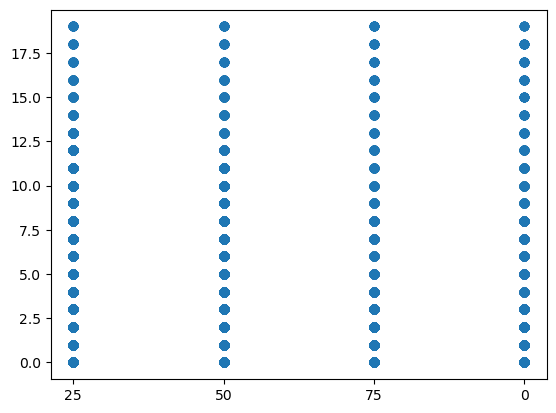

In [7]:
plt.scatter(df['time'],df['width'])

<Figure size 640x480 with 0 Axes>

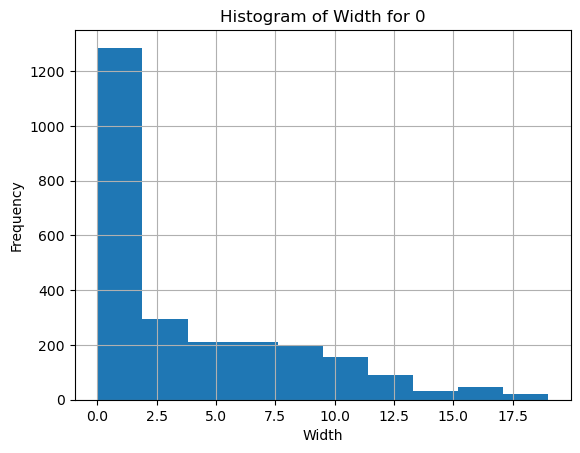

<Figure size 640x480 with 0 Axes>

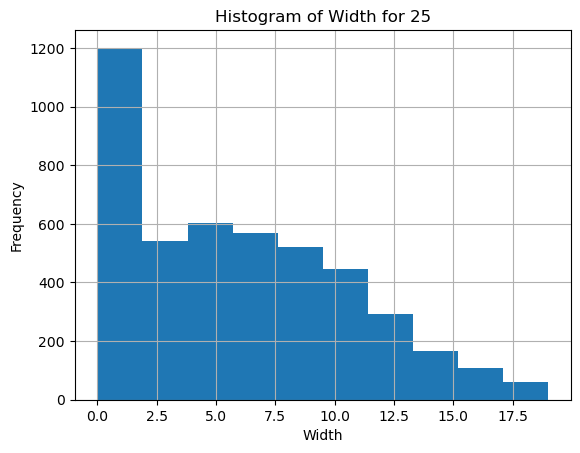

<Figure size 640x480 with 0 Axes>

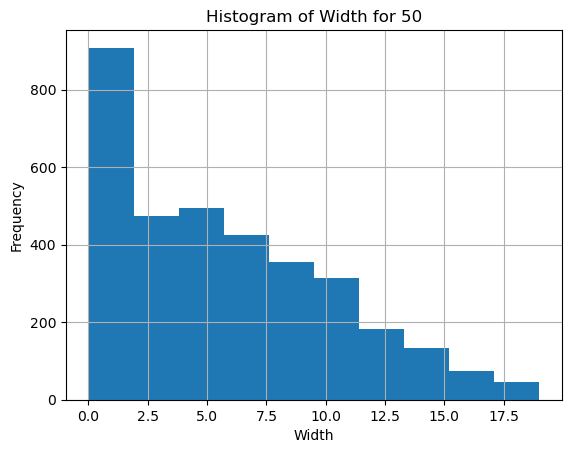

<Figure size 640x480 with 0 Axes>

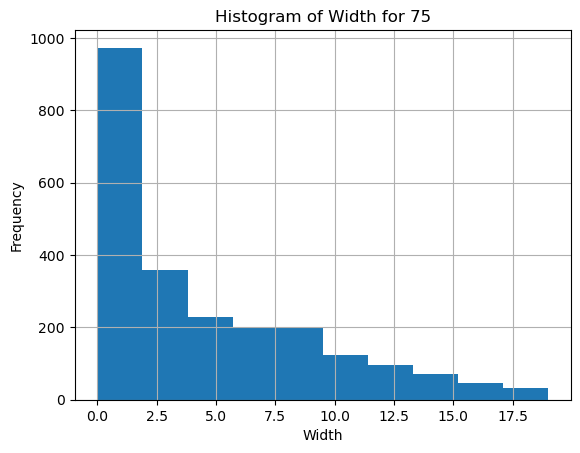

In [8]:
# Group DataFrame by 'time' column
grouped = df.groupby('time')

# Plot histograms for each group
for time, group in grouped:
    plt.figure()  # Create a new figure for each group
    group.hist(column='width', bins=10)  # Plot histogram for 'width' column
    plt.title(f'Histogram of Width for {time.capitalize()}')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.show()